In [1]:
print("hello")

hello


In [2]:
# ============================================
# 1. ライブラリ & モデル準備
# ============================================
import os
import math
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# ---- モデル名は環境に合わせて変更してください ----
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"  # 例: Qwenなどに変えてもOK

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)
model.eval()

Using device: cuda


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((3584,), eps=1e-06)
    (ro

In [3]:
# ============================================
# 2. プロンプトの用意（ML系研究アイデア）
# ============================================

BASE_INSTRUCTION = """\
You are a machine learning researcher.
Given the following topic, propose ONE concise research idea (2-4 sentences).
Avoid very generic ideas; make it slightly specific but still simple.
Write in English.
"""

topics = [
    "data augmentation for image classification",
    "robustness against adversarial examples",
    "self-supervised learning for time series",
    "efficient fine-tuning methods for large language models",
    "reinforcement learning for recommendation systems",
    "uncertainty estimation in deep neural networks",
    "multi-modal learning with text and images",
    "domain adaptation for medical imaging",
    "continual learning without catastrophic forgetting",
    "explainability methods for black-box models"
]

def build_prompt(topic: str) -> str:
    return BASE_INSTRUCTION + f"\n\nTopic: {topic}\n\nResearch idea:"
    
prompts = [build_prompt(t) for t in topics]
len(prompts), prompts[0]

(10,
 'You are a machine learning researcher.\nGiven the following topic, propose ONE concise research idea (2-4 sentences).\nAvoid very generic ideas; make it slightly specific but still simple.\nWrite in English.\n\n\nTopic: data augmentation for image classification\n\nResearch idea:')

In [4]:
# ============================================
# 3. 生成 & hidden 抽出関数
# ============================================

@torch.no_grad()
def generate_one_with_hidden(
    prompt: str,
    max_new_tokens: int = 128,
    temperature: float = 1.0,
    top_p: float = 0.95,
) -> Dict[str, Any]:
    """
    1つのプロンプトに対してテキスト生成 & hidden抽出。
    - まず generate でテキストを出す
    - その後、input+output 全体を再度 model に通して hidden_states を取得
    """
    # --- 1. テキスト生成 ---
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    gen_config = GenerationConfig(
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.pad_token_id,
    )

    gen_out = model.generate(
        **inputs,
        generation_config=gen_config,
        return_dict_in_generate=True,
        output_scores=False
    )
    output_ids = gen_out.sequences[0]  # [seq_len]
    full_text = tokenizer.decode(output_ids, skip_special_tokens=True)

    # --- 2. hidden 抽出（full_textを再度 forward） ---
    full_inputs = tokenizer(full_text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out = model(
            **full_inputs,
            output_hidden_states=True,
            return_dict=True
        )
    # hidden_states: Tuple[num_layers+1, batch, seq_len, hidden_dim]
    hidden_states = out.hidden_states
    last_hidden = hidden_states[-1][0]   # [seq_len, hidden_dim]

    # EOS の位置 → 最後の token を EOS 代わりに使う
    eos_hidden = last_hidden[-1, :]      # [hidden_dim]

    return {
        "prompt": prompt,
        "full_text": full_text,
        "output_ids": output_ids.cpu(),
        "eos_hidden": eos_hidden.cpu(),  # CPU に戻す
    }


@torch.no_grad()
def generate_multiple_for_prompt(
    prompt: str,
    num_samples: int = 5,
    max_new_tokens: int = 128,
    temperature: float = 1.0,
    top_p: float = 0.95,
) -> List[Dict[str, Any]]:
    results = []
    for i in range(num_samples):
        res = generate_one_with_hidden(
            prompt,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
        )
        res["sample_idx"] = i
        results.append(res)
    return results

In [5]:
# ============================================
# 4. 全プロンプトに対する生成 & hidden収集
# ============================================

NUM_SAMPLES_PER_PROMPT = 10

all_results = []  # list of dicts

for topic, prompt in zip(topics, prompts):
    print(f"=== Topic: {topic} ===")
    topic_results = generate_multiple_for_prompt(
        prompt,
        num_samples=NUM_SAMPLES_PER_PROMPT,
        max_new_tokens=128,
        temperature=1.0,
        top_p=0.95,
    )
    for r in topic_results:
        r["topic"] = topic
    all_results.extend(topic_results)

len(all_results)

=== Topic: data augmentation for image classification ===
=== Topic: robustness against adversarial examples ===
=== Topic: self-supervised learning for time series ===
=== Topic: efficient fine-tuning methods for large language models ===
=== Topic: reinforcement learning for recommendation systems ===
=== Topic: uncertainty estimation in deep neural networks ===
=== Topic: multi-modal learning with text and images ===
=== Topic: domain adaptation for medical imaging ===
=== Topic: continual learning without catastrophic forgetting ===
=== Topic: explainability methods for black-box models ===


100

In [6]:
# ============================================
# 5. 出力テキストの多様性スコア（簡易版）
# ============================================

from itertools import combinations

def jaccard_distance(a_tokens: List[str], b_tokens: List[str]) -> float:
    set_a = set(a_tokens)
    set_b = set(b_tokens)
    inter = len(set_a & set_b)
    union = len(set_a | set_b)
    if union == 0:
        return 0.0
    return 1.0 - inter / union

def diversity_score_for_texts(texts: List[str]) -> float:
    """
    同一トピックで得られた複数のアイデア（texts）について、
    Jaccard距離の平均を diversity とする。
    """
    if len(texts) < 2:
        return 0.0
    dists = []
    tokenized = [t.lower().split() for t in texts]
    for i, j in combinations(range(len(texts)), 2):
        d = jaccard_distance(tokenized[i], tokenized[j])
        dists.append(d)
    return float(np.mean(dists))

# topic ごとの diversity を計算
topic_to_texts: Dict[str, List[str]] = {}
topic_to_hidden: Dict[str, List[torch.Tensor]] = {}

for r in all_results:
    topic = r["topic"]
    topic_to_texts.setdefault(topic, []).append(r["full_text"])
    topic_to_hidden.setdefault(topic, []).append(r["eos_hidden"])

topic_diversity: Dict[str, float] = {}
for topic, texts in topic_to_texts.items():
    score = diversity_score_for_texts(texts)
    topic_diversity[topic] = score
    print(f"Topic: {topic} | diversity = {score:.3f}")

Topic: data augmentation for image classification | diversity = 0.586
Topic: robustness against adversarial examples | diversity = 0.594
Topic: self-supervised learning for time series | diversity = 0.596
Topic: efficient fine-tuning methods for large language models | diversity = 0.562
Topic: reinforcement learning for recommendation systems | diversity = 0.603
Topic: uncertainty estimation in deep neural networks | diversity = 0.567
Topic: multi-modal learning with text and images | diversity = 0.635
Topic: domain adaptation for medical imaging | diversity = 0.602
Topic: continual learning without catastrophic forgetting | diversity = 0.620
Topic: explainability methods for black-box models | diversity = 0.606


In [7]:
# ============================================
# 6. 高多様性 vs 低多様性トピックの選別
# ============================================

sorted_topics = sorted(topic_diversity.items(), key=lambda x: x[1], reverse=True)
print("=== Sorted topics by diversity ===")
for t, s in sorted_topics:
    print(f"{s:.3f}  -  {t}")

NUM_HIGH = 3
NUM_LOW = 3

high_topics = [t for t, _ in sorted_topics[:NUM_HIGH]]
low_topics  = [t for t, _ in sorted_topics[-NUM_LOW:]]

print("\nHigh diversity topics:", high_topics)
print("Low  diversity topics:", low_topics)

=== Sorted topics by diversity ===
0.635  -  multi-modal learning with text and images
0.620  -  continual learning without catastrophic forgetting
0.606  -  explainability methods for black-box models
0.603  -  reinforcement learning for recommendation systems
0.602  -  domain adaptation for medical imaging
0.596  -  self-supervised learning for time series
0.594  -  robustness against adversarial examples
0.586  -  data augmentation for image classification
0.567  -  uncertainty estimation in deep neural networks
0.562  -  efficient fine-tuning methods for large language models

High diversity topics: ['multi-modal learning with text and images', 'continual learning without catastrophic forgetting', 'explainability methods for black-box models']
Low  diversity topics: ['data augmentation for image classification', 'uncertainty estimation in deep neural networks', 'efficient fine-tuning methods for large language models']


In [8]:
# ============================================
# 7. 内部特徴量の集約
# ============================================

def stack_hidden_for_topics(topics_sel: List[str]) -> torch.Tensor:
    xs = []
    for r in all_results:
        if r["topic"] in topics_sel:
            xs.append(r["eos_hidden"])
    return torch.stack(xs, dim=0)  # [N, hidden_dim]

high_hidden = stack_hidden_for_topics(high_topics)
low_hidden  = stack_hidden_for_topics(low_topics)

print("High group hidden:", high_hidden.shape)
print("Low  group hidden:", low_hidden.shape)

# 簡単な統計
def describe_hidden(h: torch.Tensor, name: str):
    mean_norm = torch.norm(h, dim=-1).mean().item()
    var_norm = torch.var(torch.norm(h, dim=-1)).item()
    print(f"[{name}] mean ||h|| = {mean_norm:.3f}, var ||h|| = {var_norm:.3f}")

describe_hidden(high_hidden, "HIGH")
describe_hidden(low_hidden,  "LOW")

High group hidden: torch.Size([30, 3584])
Low  group hidden: torch.Size([30, 3584])
[HIGH] mean ||h|| = 298.250, var ||h|| = 447.250
[LOW] mean ||h|| = 303.500, var ||h|| = 167.750


In [9]:
# ============================================
# 8. 多様性サブスペースの構築（PCA）
# ============================================
from sklearn.decomposition import PCA

SUBSPACE_DIM = 8  # 好きに調整可

def build_diversity_subspace(
    high_hidden: torch.Tensor,
    subspace_dim: int = SUBSPACE_DIM,
) -> Dict[str, Any]:
    """
    高多様性グループの EOS hidden から PCA サブスペースを構築。
    """
    h_np = high_hidden.numpy()  # [N, D]
    pca = PCA(n_components=subspace_dim)
    pca.fit(h_np)
    basis = pca.components_.astype(np.float32)  # [k, D]
    basis_t = torch.from_numpy(basis)          # [k, D]
    explained = pca.explained_variance_ratio_.sum()
    print(f"Subspace dim={subspace_dim}, explained variance sum={explained:.4f}")
    return {
        "basis": basis_t,
        "pca": pca,
    }

subspace_info = build_diversity_subspace(high_hidden, SUBSPACE_DIM)
div_basis = subspace_info["basis"]  # [k, D]
div_basis.shape

Subspace dim=8, explained variance sum=0.7649


torch.Size([8, 3584])

In [10]:
class DiversitySubspaceModel:
    """
    Representation Diversity Subspace:
    - basis: [k, D]
    - project: h -> z
    - diversity_score: 複数サンプルのzから分散や距離を計算
    """
    def __init__(self, basis: torch.Tensor):
        """
        basis: [k, D]
        """
        self.basis = basis  # [k, D], float32
        self.k, self.D = basis.shape
    
    def project(self, h: torch.Tensor) -> torch.Tensor:
        """
        h: [N, D] or [D]
        return: [N, k] or [k]
        """
        if h.ndim == 1:
            h = h.unsqueeze(0)  # [1, D]
            single = True
        else:
            single = False
        
        # dtype を basis に合わせる
        if h.dtype != self.basis.dtype:
            h = h.to(self.basis.dtype)
        
        assert h.shape[-1] == self.D, f"dim mismatch: {h.shape[-1]} vs {self.D}"
        z = h @ self.basis.t()  # [N, k]
        if single:
            return z[0]
        return z
    
    def diversity_var(self, h_list: torch.Tensor) -> float:
        """
        h_list: [N, D]
        サブスペース上の分散で多様性を測る。
        """
        z = self.project(h_list)  # [N, k]
        var_per_dim = torch.var(z, dim=0, unbiased=False)  # [k]
        return var_per_dim.mean().item()
    
    def diversity_dist(self, h_list: torch.Tensor) -> float:
        """
        h_list: [N, D]
        サブスペース上の平均 pairwise L2 距離で多様性を測る。
        """
        z = self.project(h_list)  # [N, k]
        N = z.shape[0]
        if N < 2:
            return 0.0
        dists = []
        for i in range(N):
            for j in range(i+1, N):
                d = torch.dist(z[i], z[j], p=2)
                dists.append(d.item())
        return float(np.mean(dists))

div_model = DiversitySubspaceModel(div_basis)
print("DiversitySubspaceModel: k =", div_model.k, "| D =", div_model.D)

DiversitySubspaceModel: k = 8 | D = 3584


In [11]:
# ============================================
# 10. 高多様性 & 低多様性トピックでサブスペース多様性を比較
# ============================================

def get_hidden_group_by_topic(topic_sel: str) -> torch.Tensor:
    xs = []
    for r in all_results:
        if r["topic"] == topic_sel:
            xs.append(r["eos_hidden"])
    return torch.stack(xs, dim=0)  # [N_samp, D]

print("=== Diversity in subspace (var-based) ===")
for topic in high_topics + low_topics:
    h_group = get_hidden_group_by_topic(topic)
    div_var = div_model.diversity_var(h_group)
    div_dist = div_model.diversity_dist(h_group)
    print(f"Topic: {topic}")
    print(f"  - subspace variance diversity: {div_var:.4f}")
    print(f"  - subspace distance diversity: {div_dist:.4f}")

=== Diversity in subspace (var-based) ===
Topic: multi-modal learning with text and images
  - subspace variance diversity: 4543.1948
  - subspace distance diversity: 251.4877
Topic: continual learning without catastrophic forgetting
  - subspace variance diversity: 5257.7666
  - subspace distance diversity: 285.6130
Topic: explainability methods for black-box models
  - subspace variance diversity: 5486.0977
  - subspace distance diversity: 294.2351
Topic: data augmentation for image classification
  - subspace variance diversity: 3651.8093
  - subspace distance diversity: 224.4580
Topic: uncertainty estimation in deep neural networks
  - subspace variance diversity: 146.4319
  - subspace distance diversity: 43.9602
Topic: efficient fine-tuning methods for large language models
  - subspace variance diversity: 3343.8940
  - subspace distance diversity: 208.6418


# 追加デバッグ

In [12]:
# ============================================
# 6-1. 全10トピックの text / subspace 多様性を集計
# ============================================
import pandas as pd

# もし定義が残っていない場合は、再掲（コメントアウト解除して使う）
# from itertools import combinations
# def jaccard_distance(a_tokens, b_tokens):
#     set_a, set_b = set(a_tokens), set(b_tokens)
#     inter = len(set_a & set_b)
#     union = len(set_a | set_b)
#     return 0.0 if union == 0 else 1.0 - inter / union

# def diversity_score_for_texts(texts):
#     if len(texts) < 2:
#         return 0.0
#     tokenized = [t.lower().split() for t in texts]
#     dists = []
#     for i in range(len(texts)):
#         for j in range(i+1, len(texts)):
#             dists.append(jaccard_distance(tokenized[i], tokenized[j]))
#     return float(np.mean(dists))

# topic -> texts / hidden を再構築（念のため）
topic_to_texts: Dict[str, List[str]] = {}
topic_to_hidden: Dict[str, List[torch.Tensor]] = {}

for r in all_results:
    topic = r["topic"]
    topic_to_texts.setdefault(topic, []).append(r["full_text"])
    topic_to_hidden.setdefault(topic, []).append(r["eos_hidden"])

rows = []
for topic, texts in topic_to_texts.items():
    # 1) テキスト多様性（Jaccard）
    text_div = diversity_score_for_texts(texts)
    # 2) 内部表現（EOS hidden）
    h_group = torch.stack(topic_to_hidden[topic], dim=0)  # [N_samp, D]
    # 3) サブスペース多様性（分散＆距離）
    sub_var = div_model.diversity_var(h_group)
    sub_dist = div_model.diversity_dist(h_group)
    rows.append({
        "topic": topic,
        "text_diversity": text_div,
        "subspace_div_var": sub_var,
        "subspace_div_dist": sub_dist,
        "num_samples": h_group.shape[0],
    })

df_div = pd.DataFrame(rows).sort_values("text_diversity", ascending=False)
df_div

,topic,text_diversity,subspace_div_var,subspace_div_dist,num_samples
6,multi-modal learning with text and images,0.635459,4543.194824,251.487724,10
8,continual learning without catastrophic forget...,0.620129,5257.766602,285.612953,10
9,explainability methods for black-box models,0.605608,5486.097656,294.235120,10
4,reinforcement learning for recommendation systems,0.603301,4118.375000,246.016195,10
7,domain adaptation for medical imaging,0.601683,3554.543213,222.344732,10
2,self-supervised learning for time series,0.595820,2909.253418,184.589586,10
1,robustness against adversarial examples,0.594337,3135.893555,211.917818,10
0,data augmentation for image classification,0.586390,3651.809326,224.457994,10
5,uncertainty estimation in deep neural networks,0.567395,146.431854,43.960210,10
3,efficient fine-tuning methods for large langua...,0.562124,3343.894043,208.641759,10


In [13]:
# ============================================
# 6-2. 相関係数の計算
# ============================================

corr_var = df_div["text_diversity"].corr(df_div["subspace_div_var"])
corr_dist = df_div["text_diversity"].corr(df_div["subspace_div_dist"])

print("Correlation(text_diversity, subspace_div_var)  =", corr_var)
print("Correlation(text_diversity, subspace_div_dist) =", corr_dist)

Correlation(text_diversity, subspace_div_var)  = 0.6965763339552837
Correlation(text_diversity, subspace_div_dist) = 0.662923435912212


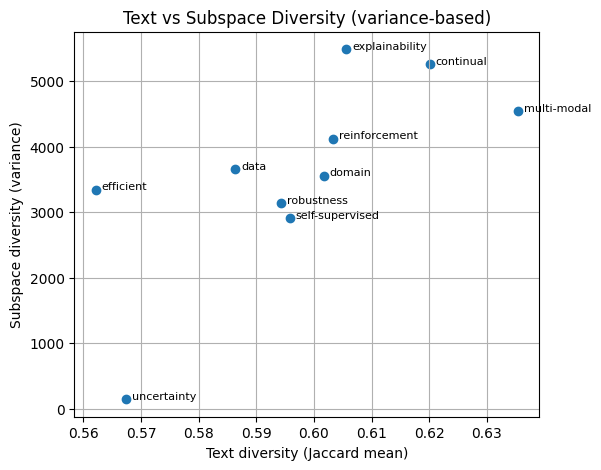

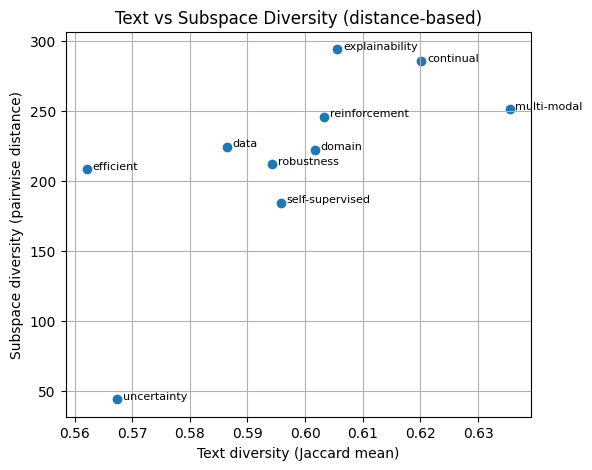

In [14]:
# ============================================
# 6-3. 散布図の描画
# ============================================
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_div["text_diversity"], df_div["subspace_div_var"])
for _, row in df_div.iterrows():
    plt.text(row["text_diversity"] + 0.001, row["subspace_div_var"], row["topic"].split()[0], fontsize=8)
plt.xlabel("Text diversity (Jaccard mean)")
plt.ylabel("Subspace diversity (variance)")
plt.title("Text vs Subspace Diversity (variance-based)")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(df_div["text_diversity"], df_div["subspace_div_dist"])
for _, row in df_div.iterrows():
    plt.text(row["text_diversity"] + 0.001, row["subspace_div_dist"], row["topic"].split()[0], fontsize=8)
plt.xlabel("Text diversity (Jaccard mean)")
plt.ylabel("Subspace diversity (pairwise distance)")
plt.title("Text vs Subspace Diversity (distance-based)")
plt.grid(True)
plt.show()

# 新トピック

In [15]:
# ============================================
# 6-5. 新しいトピック群での汎化テスト
# ============================================

new_topics = [
    "graph neural networks for traffic prediction",
    "causal inference with deep learning",
    "contrastive learning for speech recognition",
    "federated learning with heterogeneous clients",
    "meta-learning for few-shot classification",
]

def build_prompt(topic: str) -> str:
    return BASE_INSTRUCTION + f"\n\nTopic: {topic}\n\nResearch idea:"

new_prompts = [build_prompt(t) for t in new_topics]

new_results = []
for topic, prompt in zip(new_topics, new_prompts):
    print(f"=== [NEW] Topic: {topic} ===")
    topic_results = generate_multiple_for_prompt(
        prompt,
        num_samples=NUM_SAMPLES_PER_PROMPT,  # 既存と同じ or 好きな数
        max_new_tokens=128,
        temperature=1.0,
        top_p=0.95,
    )
    for r in topic_results:
        r["topic"] = topic
    new_results.extend(topic_results)

len(new_results)

=== [NEW] Topic: graph neural networks for traffic prediction ===
=== [NEW] Topic: causal inference with deep learning ===
=== [NEW] Topic: contrastive learning for speech recognition ===
=== [NEW] Topic: federated learning with heterogeneous clients ===
=== [NEW] Topic: meta-learning for few-shot classification ===


50

In [16]:
# ============================================
# 6-6. 新トピック群の多様性を評価（subspaceは既存のまま）
# ============================================

# text / hidden を構築
new_topic_to_texts: Dict[str, List[str]] = {}
new_topic_to_hidden: Dict[str, List[torch.Tensor]] = {}

for r in new_results:
    topic = r["topic"]
    new_topic_to_texts.setdefault(topic, []).append(r["full_text"])
    new_topic_to_hidden.setdefault(topic, []).append(r["eos_hidden"])

new_rows = []
for topic, texts in new_topic_to_texts.items():
    text_div = diversity_score_for_texts(texts)
    h_group = torch.stack(new_topic_to_hidden[topic], dim=0)
    sub_var = div_model.diversity_var(h_group)   # ← 既存のサブスペースをそのまま使用
    sub_dist = div_model.diversity_dist(h_group)
    new_rows.append({
        "topic": topic,
        "text_diversity": text_div,
        "subspace_div_var": sub_var,
        "subspace_div_dist": sub_dist,
        "num_samples": h_group.shape[0],
    })

df_new_div = pd.DataFrame(new_rows).sort_values("text_diversity", ascending=False)
df_new_div

,topic,text_diversity,subspace_div_var,subspace_div_dist,num_samples
1,causal inference with deep learning,0.629818,3448.520752,214.973605,10
4,meta-learning for few-shot classification,0.612333,3425.849854,219.118308,10
2,contrastive learning for speech recognition,0.607252,1752.125000,137.512463,10
0,graph neural networks for traffic prediction,0.598903,3491.428955,221.272968,10
3,federated learning with heterogeneous clients,0.579483,2660.186279,181.697880,10


NEW Correlation(text_diversity, subspace_div_var)  = 0.3090083461492317
NEW Correlation(text_diversity, subspace_div_dist) = 0.2728108110424786


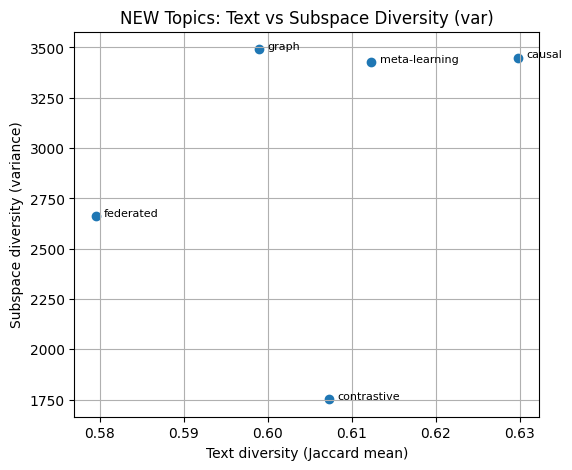

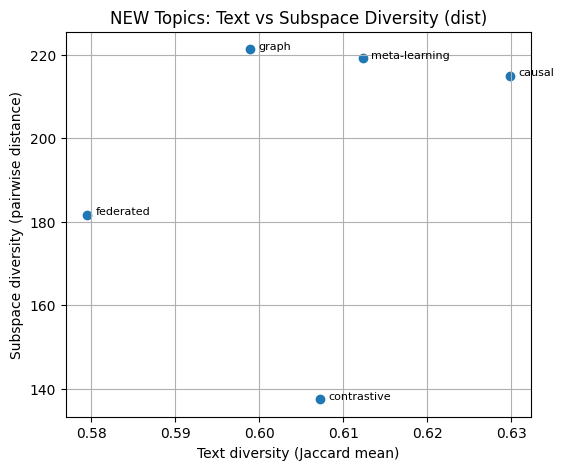

In [17]:
# ============================================
# 6-7. 新トピックの相関 & 散布図
# ============================================

corr_var_new = df_new_div["text_diversity"].corr(df_new_div["subspace_div_var"])
corr_dist_new = df_new_div["text_diversity"].corr(df_new_div["subspace_div_dist"])

print("NEW Correlation(text_diversity, subspace_div_var)  =", corr_var_new)
print("NEW Correlation(text_diversity, subspace_div_dist) =", corr_dist_new)

plt.figure(figsize=(6, 5))
plt.scatter(df_new_div["text_diversity"], df_new_div["subspace_div_var"])
for _, row in df_new_div.iterrows():
    plt.text(row["text_diversity"] + 0.001, row["subspace_div_var"], row["topic"].split()[0], fontsize=8)
plt.xlabel("Text diversity (Jaccard mean)")
plt.ylabel("Subspace diversity (variance)")
plt.title("NEW Topics: Text vs Subspace Diversity (var)")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(df_new_div["text_diversity"], df_new_div["subspace_div_dist"])
for _, row in df_new_div.iterrows():
    plt.text(row["text_diversity"] + 0.001, row["subspace_div_dist"], row["topic"].split()[0], fontsize=8)
plt.xlabel("Text diversity (Jaccard mean)")
plt.ylabel("Subspace diversity (pairwise distance)")
plt.title("NEW Topics: Text vs Subspace Diversity (dist)")
plt.grid(True)
plt.show()